# Algorithms for exact computation for particular cases

In this notebook, we present the code for computing the Benzhaf-Penrose index of voters when the underlying graph is either bipartite (Section 4 - Proxy Voting) or complete (Section 5)

In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})


In the following cell, we import the code of Lemma 1 mentioned in Appendix A.1.

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("./python/"))
from lemma_one import getAll2partitions, getAll3partitions, getAll4partitions

## Proxy voting - Bipartite graph (Section 4)

In the following cell, we simply implement the Equation 1 and 2 of the paper

In [3]:
def proba_v(nv, nd, nv_p, nd_p, nd_m, p_d): # this corresponds to Equation 1 in the paper
    nv_m = nv - 1 - nv_p
    nd_i = nd - nd_p - nd_m
    p_v = 1 - p_d
    return (1/(2**(nv-1)))*((p_v/2+p_d*(nv_p/nv))**nd_p)*((p_v/2+p_d*(nv_m/nv))**nd_m)*((p_d/nv)**nd_i)


def proba_d(nv, nd, nv_p, nd_p, p_d):# this corresponds to Equation 2 in the paper
    nv_m = nv - nv_p
    nd_m = nd - 1 - nd_p
    p_v = 1 - p_d
    return (1/(2**nv))*((p_v/2+p_d*(nv_p/nv))**nd_p)*((p_v/2+p_d*(nv_m/nv))**nd_m)
        

The following code corresponds to the computation in Equation 2 (Section 4) given that we are in a weighted voting game with quota $q$ and weights $w_d, w_v$.

In [4]:
def powers_PV_WVG(wd, wv, q, p_d):
    '''
    wd: weight vector of V_d
    wv: weight vector of V_v
    q: quota s.t. 0 < q < 1
    p_d: probability to delegates
    '''
    nd = len(wd) #number of delegators
    nv = len(wv) #number of delegatees
    wds = int(np.sum(wd)) #total sum of weights of the delegators
    wvs = int(np.sum(wv)) #total sum of weights of the delegatees
    ws = wds + wvs #total sum of the agents' weights 
    
    power_v = {}
    #for the delegatees (voting agents)
    for i in range(nv): # for delegatee i
        w_i = wv[i] #find i's weight
        if w_i in power_v: #if the power measure has already been found for a delegatee then we don't compute it again
            continue
        w_not_i = np.concatenate([wv[:i],wv[i+1:]]) #remove i from the weight vector of delegatees
        mv = getAll2partitions(w_not_i) #find all 2 partitions of the delegatees not involving i: (1) those in favour; (2) those against
        md = getAll3partitions(wd)  #find all 3 partitions of the delegators: (1) those delegating to a proxy in favour; (2) those delegating to a proxy against; (3) those delegating to i

        p_tot = 0 #starting value of total prob of being critical
        for nd_p in range(nd+1): #for each of the possible number of delegators in favour
            for nd_m in range(nd+1-nd_p): # for each of the possible number of delegators against given the number of delegators in favour
                for nv_p in range(nv): #for each of the possible number delegatees being in favour
                    p = proba_v(nv, nd, nv_p, nd_p, nd_m, p_d) #the probability of this partition happening without i (given that i is a delegatee)
                    for wd_p in range(wds+1): # the possible total weights of the delegators in favour
                        for wd_m in range(wds+1-wd_p):# the possible total weights of the delegators against, given the total weights in favour
                            for wv_p in range(wvs+1-w_i):# the possible total weights of the delegatees in favour including the weights from delegations
                                w_p = wv_p + wd_p #the total voting weight in favour (from both the delegators and the delegatees)
                                wd_i = (wds - wd_p - wd_m) + w_i #the total voting weight of i and those delegating to i
                                gamma_1 = mv[nv_p, wv_p]  #the number of ways to have a partition of delegatees (without i) given the number of delegatees in favour
                                gamma_2 = md[nd_p, nd_m, wd_p, wd_m] # the number of ways for the delegators to be partitioned
                                if w_p < q*ws and w_p + wd_i >= q*ws: #if within this partition i is critical
                                    if gamma_1 > 0 and gamma_2 > 0: #if these partitions are possible
                                        p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) times by the probability of it happening
                                        
        power_v[w_i] = p_tot #returns the power of a delegatee with weight w_i
        
        
    #for the delegators 
    power_d = {}
    for i in range(nd): #for each delegator i
        w_i = wd[i] #fing i's weight 
        if w_i in power_d: #if the power measure has already been found for this weight, then skip
            continue
        w_not_i = np.concatenate([wd[:i],wd[i+1:]]) #removing i from the from the delegators weights 
        mv = getAll2partitions(wv)#find all ways of splitting the delegatees into those in favour and those against  (with respect to their weights)
        md = getAll2partitions(w_not_i) #find all of the ways of splitting the delegators (expect the agent in question, i) into those delegating to a proxy in favour and those delegating to a proxy against
        
        p_tot = 0 #starting value of total prob of being critical
        for nd_p in range(nd): #for every possible number of delegators in favour
            for nv_p in range(nv+1): # for every possible number of delegatees in favour
                p = proba_d(nv, nd, nv_p, nd_p, p_d) #the probability of this partition happening without i (given that i is a delegator)
                for wd_p in range(wds+1-w_i):# #for every possible weight out of the total weights of the delegators without i
                    for wv_p in range(wvs+1):# for every possible sum of the weight of the delegatees who are in favour
                        w_p = wv_p + wd_p #the total weight of voters in favour 
                        gamma_1 = mv[nv_p, wv_p]  # the number of ways of having a partition of the delegatees given the number of those in favour and their weights
                        gamma_2 = md[nd_p, wd_p] # the number of ways of having a partition of the delegators given the number of those in favour and their weights
                        if w_p < q*ws and w_p + w_i >= q*ws:#if within this partition i is critical
                            if gamma_1 > 0 and gamma_2 > 0: #if these partitions are possible
                                p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) times by the probability of it happening
                       
        power_d[w_i] = p_tot #returns the power of a delegator with weight w_i
        
        
    return power_v, power_d  #this returns the first the power of the delegatees with respect to their weights, and then the same for the delegators

In the following cell, we run the code to obtain Table 1, i.e. we compute the voting power $\mathcal{M}^{LD}$ of the agents in Example 2 when the probability of delegating is $p_d=0, 0.5, 0.9$ (as seen in Table 1)

In [5]:
table = [["p_d = 0", "p_d = 0.5",  "p_d = 0.9"]] + [[""]*4 for x in range(5)]

for x in range(1,4):
    table[x][0] = "V_v (w=%s)"%str(x)
for x in range(1,3):
    table[x+3][0] = "V_d (w=%s)"%str(x)

for j,p_d in enumerate([0, 0.5, 0.9]):

    power_v, power_d = powers_PV_WVG([1]*9+[2], [3,2,1], 0.5, p_d)

    for x in range(1,4):
        table[x][j+1] = power_v[x]
    for x in range(1,3):
        table[x+3][j+1]= power_d[x]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤═══════════╤═════════════╤═════════════╕
│           │   p_d = 0 │   p_d = 0.5 │   p_d = 0.9 │
╞═══════════╪═══════════╪═════════════╪═════════════╡
│ V_v (w=1) │  0.147949 │   0.302704  │   0.390287  │
├───────────┼───────────┼─────────────┼─────────────┤
│ V_v (w=2) │  0.306152 │   0.394627  │   0.437994  │
├───────────┼───────────┼─────────────┼─────────────┤
│ V_v (w=3) │  0.51123  │   0.552403  │   0.542343  │
├───────────┼───────────┼─────────────┼─────────────┤
│ V_d (w=1) │  0.147949 │   0.0978467 │   0.0650542 │
├───────────┼───────────┼─────────────┼─────────────┤
│ V_d (w=2) │  0.306152 │   0.206377  │   0.137562  │
╘═══════════╧═══════════╧═════════════╧═════════════╛


Next, we conduct an experiment to see the impact of $p_d$, with $|V_v| = 5$ and $|V_d| = 15$.

100%|██████████| 11/11 [00:21<00:00,  1.98s/it]
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


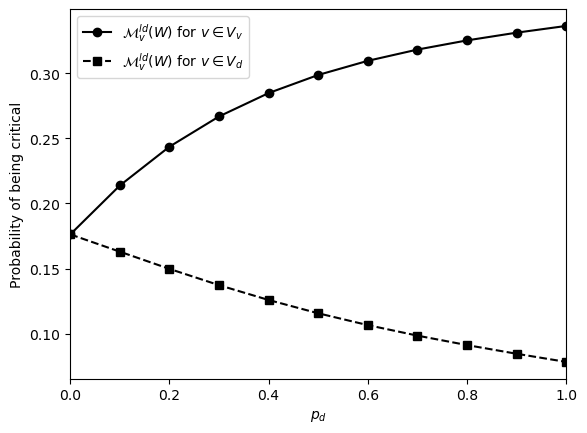

In [6]:
n_voters = 20
tab_n = np.linspace(0,1,11)
len_tab = len(tab_n)
tab_res = np.zeros((2, len_tab))

for i in tqdm(range(len(tab_n))):
    p_d = tab_n[i]
    p_v, p_d = powers_PV_WVG([1]*15, [1]*5, 0.5, p_d)
    tab_res[0, i] = p_v[1]
    if 1 in p_d:
        tab_res[1, i] = p_d[1]


plt.plot([n for n in tab_n], tab_res[0], 'o', ls = '-',label = r'$\mathcal{M}^{ld}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n], tab_res[1], 's', ls = '--',label = r'$\mathcal{M}^{ld}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(0,1)
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
plt.show()

## Complete graph (Section 5)

The following code compute the probability of Equation 3 and the equation for abstaining voter in Section 5

In [7]:

def binom(n, k):
    return math.factorial(n) // math.factorial(k) // math.factorial(n - k)

def proba_ld_0(n0, n, p_d): 
    return (p_d*(n0-1)/(n-1))**(n0)

def proba_ld(n, p, p_d):  
    tab_p_d = np.ones(n)*-1
    tab_p = np.ones(n)*-1
    tab_p[0] = 1
    tab_p_d[0] = 1
    tab_p[1] = p
    tab_p_d[1] = p_d/(n-1)
    
    def fillCell(m, pi):
        if pi == p and tab_p[m] >= 0:
            return tab_p[m]
        if pi == p_d/(n-1) and tab_p_d[m] >= 0:
            return tab_p_d[m]
        c = 0
        for m1 in range(m): 
            s = binom(m-1, m1)
            s *= fillCell(m1, p_d/(n-1))
            s *= fillCell(m - 1 - m1, pi)
            s *= (pi + p_d*(m - 1 - m1)/(n-1))
            c += s
        if pi == p:
            tab_p[m] = c
        else:
            tab_p_d[m] = c
        return c
    
    for i in range(2, n):
        tab_p[i] = fillCell(i, p)
    
    return tab_p

The following code compute the power indices of the voters with a complete graph in a WVG with quota $q$ and weights $w$.

In [8]:
def powers_complete_WVG(w, q, p_d):
    '''
    w: weight vector of V
    q: quota s.t. 0 < q < 1
    p_d: probability to delegates
    '''
    n = len(w)  #number of voters
    ws = np.sum(w) #total weights
    p_v = 1 - p_d #probability of voting is 1- probability of delegating
    
    power_v = {}
    
    pl_pv = proba_ld(n, p_v/2, p_d)  
    pl_pd = proba_ld(n, p_d/(n-1), p_d)
    
    
    for i in range(n): # for each agent
        w_i = w[i] #find their weight
        if w_i in power_v: #if the power measure for this weight has already been found, then skip
            continue
        w_not_i = np.concatenate([w[:i],w[i+1:]])
        mv = getAll4partitions(w_not_i) #find all 4-partitions of the agents without agent i: (1) agents voting in favour; (2) agents voting against; (3) agents caught in a cycle V^0; (4) agents delegating to i 
        
        p_tot = 0 
        for n_p in range(n): #for the number of possible agents in favour
            for n_m in range(n-n_p): #for the number of possible agents against given the number of those in favour
                for n_0 in range(n-n_p-n_m): #for the number of possible agents in a cycle given the number of those in favour and those against
                    n_i = n-1-n_p-n_m-n_0 #number of agents delegating to i is n  minus 1 (for i), the number of agents in favour n_p (directly or indirectly), the number of agents against n_m  (directly or indirectly), and the number of agents caught in a cycle 
                    p = proba_ld_0(n_0, n, p_d)  #probability of those in V^0 being in a cycle
                    p *= pl_pv[n_p] #probability of the n_p agents in V^+ voting for the issue (either directly or indirectly) 
                    p *= pl_pv[n_m] #probability of the n_m agents in V^- voting against the issue (either directly or indirectly) 
                    p *= pl_pd[n_i] #probability of the n_i agents in V^i delegating to i (directly or indirectly)
                    for w_p in range(ws+1-w_i):  #for the possible total weight of the agents in favour
                        for w_m in range(ws+1-w_i-w_p): #for the possible total weight of the agents against 
                            for w_0 in range(ws+1-w_i-w_p-w_m): #for the possible total weight of the agents in a cycle
                                wd_i = ws - w_p - w_m - w_0 - w_i #given the values of w_p, w_m, and w_0
                                w_i_tot = wd_i + w_i # agent i's voting weight is their own weight and that of those delegating to them
                                gamma = mv[n_p, n_m, n_0, w_p, w_m, w_0] #get the number of 4-partitions of these weights and sizes of V^+, V^- and V^0
                                if w_p < q*(ws-w_0) and w_p + w_i_tot >= q*(ws-w_0): #are they critical
                                    if gamma > 0: #does such a partition exist
                                        p_tot += gamma*p #add the number of times this partition happens times by the probability of it happening and add it to the total
                                    
        power_v[w_i] = p_tot # add the power measure for agents with this weight
        
    return power_v   #this returns the power of the agents with respect to their weights

In the following cell, we run the code to obtain Table 2, i.e. we compute the voting power $\mathcal{M}^{LD}$ of the agents in Example 3 when the probability of delegating is $p_d=0, 0.5, 0.9$ (as seen in Table 2)

In [9]:
table = [["p_d = 0", "p_d = 0.5",  "p_d = 0.9"]] + [[""]*4 for x in range(3)]

for x in range(1,4):
    table[x][0] = "w=%s"%str(x)

for j,p_d in enumerate([0, 0.5, 0.9]):

    power_v = powers_complete_WVG([1]*10+[2]*2+[3], 0.5, p_d)

    for x in range(1,4):
        table[x][j+1] = power_v[x]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒═════╤═══════════╤═════════════╤═════════════╕
│     │   p_d = 0 │   p_d = 0.5 │   p_d = 0.9 │
╞═════╪═══════════╪═════════════╪═════════════╡
│ w=1 │  0.147949 │    0.211862 │    0.568158 │
├─────┼───────────┼─────────────┼─────────────┤
│ w=2 │  0.306152 │    0.308253 │    0.638063 │
├─────┼───────────┼─────────────┼─────────────┤
│ w=3 │  0.51123  │    0.4241   │    0.69638  │
╘═════╧═══════════╧═════════════╧═════════════╛


We also conducted an experiment with voters of different weights ($w \in \{1,2,5\}$) as in Figure 3 of our paper, but with less voters.

100%|██████████| 10/10 [19:58<00:00, 119.88s/it]


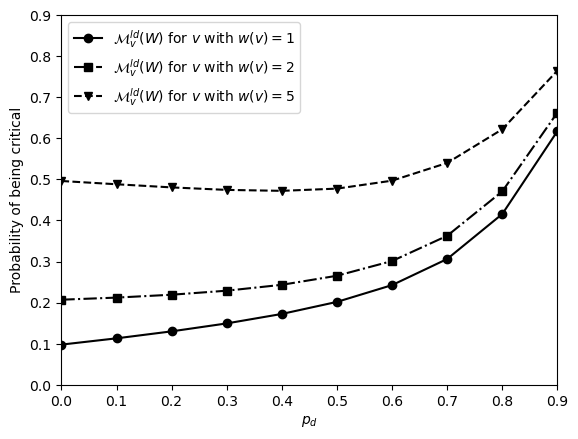

In [10]:
n_voters = 20
tab_n = np.linspace(0,0.9,10)
len_tab = len(tab_n)
tab_res = np.zeros((3,len_tab))

for i in tqdm(range(len(tab_n))):
    p_d = tab_n[i]
    p_v = powers_complete_WVG([1]*5+[2]*3+[5]*2, 0.5, p_d)
    tab_res[0][i] = p_v[1]
    tab_res[1][i] = p_v[2]
    tab_res[2][i] = p_v[5]


plt.plot([n for n in tab_n], tab_res[0], '-o', label = r'$\mathcal{M}^{ld}_v(W)$ for $v$ with $w(v)=1$', color="black")
plt.plot([n for n in tab_n], tab_res[1], '-.s', label = r'$\mathcal{M}^{ld}_v(W)$ for $v$ with $w(v)=2$', color="black")
plt.plot([n for n in tab_n], tab_res[2], '--v', label = r'$\mathcal{M}^{ld}_v(W)$ for $v$ with $w(v)=5$', color="black")

plt.legend()
plt.xlim(0,0.9)
plt.ylim(0,0.9)
plt.xlabel(r'$p_d$')
plt.ylabel('Probability of being critical')
plt.show()

## PV-$\alpha$ model (Appendix A.3)

We know do the same computations, but for the PV-$\alpha$ model that is discussed in the Appendix

In [11]:
def proba_v_alpha(nv, nd, nv_p, nd_p, nd_m): # this corresponds to Equation 1 in the paper
    nv_m = nv - 1 - nv_p
    return ((nv_p)**(nd_p))*((nv_m)**(nd_m))/((2**(nv-1))*(nv**nd))

def proba_d_alpha(nv, nd, nv_p, nd_p):# this corresponds to Equation 3 in the paper
    nv_m = nv - nv_p
    nd_m = nd - 1 - nd_p
    return ((nv_p)**(nd_p))*((nv_m)**(nd_m))/((2**nv)*(nv**(nd-1)))

In [12]:
def powers_PV_alpha_WVG(wd, wv, q):
    '''
    wd: weight vector of V_d
    wv: weight vector of V_v
    q: quota s.t. 0 < q < 1
    '''
    nd = len(wd)  #number of delegators
    nv = len(wv) #number of delegatees
    wds = int(np.sum(wd)) #total weights of the delegators
    wvs = int(np.sum(wv))#total weights of the delegatees
    ws = wds + wvs #total weights of all agents
    
    # For voting voters
    power_v = {} 
    for i in range(nv): #for a delegatee i
        w_i = wv[i] #find the voting weight of i 
        if w_i in power_v: #check that the power of the agent hasn't already been computed 
            continue
        w_not_i = np.concatenate([wv[:i],wv[i+1:]])
        mv = getAll2partitions(w_not_i)  #find all of the ways of splitting the delegatees without agent i (with respect to their weights) into those in favour and those against  
        md = getAll3partitions(wd) #find all of the ways of splitting the delegators (with respect to their weights) into 3 groups: (1) those delegating to those in favour; (2) those delegating to those against; (3) delegating to i
        
        p_tot = 0 #starting value of total prob of being critical
        for nd_p in range(nd+1): #for each of the possible number of delegators in favour
            for nd_m in range(nd+1-nd_p): # #for each of the possible number of delegators against given the number of delegators in favour
                for nv_p in range(nv): #for each of the possible number delegatees being in favour
                    p = proba_v_alpha(nv, nd, nv_p, nd_p, nd_m) #the probability of this number of agents being split in this way
                    for wd_p in range(wds+1): # the possible total weights of the delegators in favour
                        for wd_m in range(wds+1-wd_p): # the possible total weights of the delegators against, given the total weights in favour
                            for wv_p in range(wvs+1-w_i): # the possible total weights of the delegatees in favour including the weights from delegations
                                w_p = wv_p + wd_p #weight of votes in favour 
                                wd_i = (wds - wd_p - wd_m) + w_i #weight of i and those delegating to i
                                gamma_1 = mv[nv_p, wv_p]  #the number of ways to have a partition of delegatees (without i) given the number of delegatees in favour
                                gamma_2 = md[nd_p, nd_m, wd_p, wd_m] # the number of ways for the delegators to be partitioned
                                if w_p < q*ws and w_p + wd_i >= q*ws: # is i critical in this partition?
                                    if gamma_1 > 0 and gamma_2 > 0:# the partition is possible
                                        p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) times by the probability of it happening
                                    
        power_v[w_i] = p_tot #returns the power of a delegatee with weight w_i 
        
    #For delegating voters
    power_d = {}
    for i in range(nd): #for a delegator i
        w_i = wd[i] #find i's weight
        if w_i in power_d: #if the power measure has already been found for this weight, then skip
            continue
        w_not_i = np.concatenate([wd[:i],wd[i+1:]]) #removing i from the from the delegators weights 
        mv = getAll2partitions(wv) #find all ways of splitting the delegatees into those in favour and those against  (with respect to their weights)
        md = getAll2partitions(w_not_i) #find all of the ways of splitting the delegators (expect the agent in question, i) into those delegating to a proxy in favour and those delegating to a proxy against
        
        p_tot = 0 #setting the total probability to 0
        for nd_p in range(nd): # for all possible numbers of delegators being in favour
            for nv_p in range(nv+1): #for all possible numbers of delegatees being in favour
                p = proba_d_alpha(nv, nd, nv_p, nd_p)  #the probability of having a partition with this number in each group
                for wd_p in range(wds+1-w_i): # for all possible total weight of the delegators in favour
                    for wv_p in range(wvs+1): # for the possible total final voting weight of the delegatees in favour given that the delegations have been taken into account
                        w_p = wv_p + wd_p #the total weight of voters in favour 
                        gamma_1 = mv[nv_p, wv_p] # the number of ways of having a partition of the delegatees given the number of those in favour and their weights
                        gamma_2 = md[nd_p, wd_p] # the number of ways of having a partition of the delegators given the number of those in favour and their weights
                        if w_p < q*ws and w_p + w_i >= q*ws: #if within this partition i is critical 
                            if gamma_1 > 0 and gamma_2 > 0: #if these partitions are possible
                                p_tot += gamma_1*gamma_2*p #adding to the total probability of being critical, the number of ways this partition could happen  (gamma1*gamma2) timesed by the probability of it happening
                                    
        power_d[w_i] = p_tot #returns the power of a delegator with weight w_i 
        
    return power_v, power_d #this returns first the power of the delegatees with respect to their weights, and then the same for the delegators

In [13]:
table = [["p_d = 0", "p_d = 0.5",  "p_d = 0.9"]] + [[""]*2 for x in range(5)]

for x in range(1,4):
    table[x][0] = "V_v (w=%s)"%str(x)
for x in range(1,3):
    table[x+3][0] = "V_d (w=%s)"%str(x)

power_v, power_d = powers_PV_alpha_WVG([1]*9+[2], [3,2,1], 0.5)

for x in range(1,4):
    table[x][1] = power_v[x]
for x in range(1,3):
    table[x+3][1]= power_d[x]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤═════════════╕
│ p_d = 0   │   p_d = 0.5 │
╞═══════════╪═════════════╡
│ V_v (w=1) │   0.408068  │
├───────────┼─────────────┤
│ V_v (w=2) │   0.447086  │
├───────────┼─────────────┤
│ V_v (w=3) │   0.538129  │
├───────────┼─────────────┤
│ V_d (w=1) │   0.0573083 │
├───────────┼─────────────┤
│ V_d (w=2) │   0.121323  │
╘═══════════╧═════════════╛


We compare how PV and PV-$\alpha$ changes with the size of the set of proxies $V_v$ in comparison to the number of voters.

100%|██████████| 20/20 [00:57<00:00,  2.86s/it]


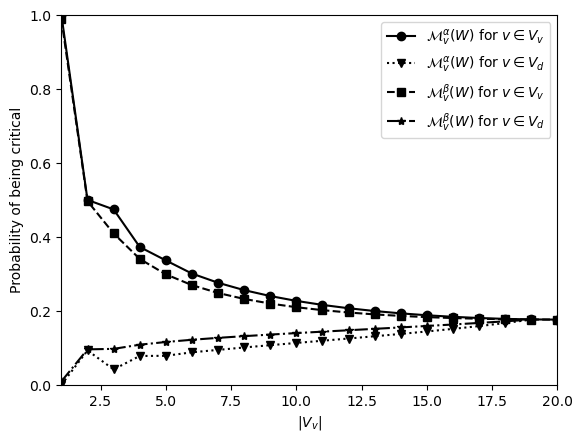

In [14]:
n_voters = 20
tab_n = range(1, n_voters+1)
len_tab = len(tab_n)
tab_res_alpha = np.zeros((2, len_tab))
tab_res = np.zeros((2, len_tab))

for i in tqdm(range(len(tab_n))):
    n = tab_n[i]
    p_v, p_d = powers_PV_alpha_WVG([1]*(n_voters-n), [1]*(n), 0.5)
    tab_res_alpha[0, i] = p_v[1]
    if 1 in p_d:
        tab_res_alpha[1, i] = p_d[1]

    
    p_v, p_d = powers_PV_WVG([1]*(n_voters-n), [1]*(n), 0.5, 0.5)
    tab_res[0, i] = p_v[1]
    if 1 in p_d:
        tab_res[1, i] = p_d[1]


plt.plot([n for n in tab_n], tab_res_alpha[0],'o', linestyle='solid' , label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res_alpha[1][:-1], 'v',linestyle='dotted', label = r'$\mathcal{M}^{\alpha}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.xlim(1,n_voters)
plt.xlabel(r'$|V_v|$')
plt.ylim(0,1)
plt.ylabel('Probability of being critical')
plt.plot([n for n in tab_n], tab_res[0], 's', linestyle = 'dashed', label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_v$', color="black")
plt.plot([n for n in tab_n[:-1]], tab_res[1][:-1], '*', linestyle = '-.' ,label = r'$\mathcal{M}^{\beta}_v(W)$ for $v \in V_d$', color="black")
plt.legend()
plt.show()